In [ ]:

# Install required libraries
!pip install torch torchvision transformers pillow opencv-python-headless

import torch
import torchvision
from PIL import Image
import numpy as np
import cv2
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to load and preprocess image
def load_image(image_path_or_url):
    if image_path_or_url.startswith("http"):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path_or_url).convert("RGB")
    return image

# Sliding window to generate candidate regions
def generate_candidate_regions(image, window_size=224, stride=112):
    img_array = np.array(image)
    height, width = img_array.shape[:2]
    regions = []
    boxes = []

    for y in range(0, height - window_size + 1, stride):
        for x in range(0, width - window_size + 1, stride):
            region = img_array[y:y+window_size, x:x+window_size]
            if region.shape[:2] == (window_size, window_size):
                regions.append(Image.fromarray(region))
                boxes.append((x, y, x+window_size, y+window_size))

    return regions, boxes

# Compute similarity between text query and image regions
def compute_similarity(regions, text_query):
    inputs = processor(text=[text_query], images=regions, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image.cpu()

    return logits_per_image.squeeze()

# Main function to localize scene
def localize_scene(image_path_or_url, text_query, top_k=1):
    # Load image
    image = load_image(image_path_or_url)
    img_array = np.array(image)

    # Generate candidate regions
    regions, boxes = generate_candidate_regions(image, window_size=224, stride=112)

    # Compute similarity scores
    scores = compute_similarity(regions, text_query)

    # Find top-k regions
    top_indices = scores.argsort(descending=True)[:top_k]
    top_boxes = [boxes[i] for i in top_indices]
    top_scores = [scores[i].item() for i in top_indices]

    # Crop and display top region
    top_box = top_boxes[0]
    cropped = img_array[top_box[1]:top_box[3], top_box[0]:top_box[2]]

    return cropped, top_box, top_scores[0]

# Demo function to visualize results
def demo(image_path_or_url, queries):
    plt.figure(figsize=(15, 5))
    original_image = load_image(image_path_or_url)

    for i, query in enumerate(queries, 1):
        cropped, box, score = localize_scene(image_path_or_url, query)

        # Plot original image with bounding box
        plt.subplot(1, len(queries)+1, 1)
        img_with_box = np.array(original_image)
        cv2.rectangle(img_with_box, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        plt.imshow(img_with_box)
        plt.title("Original with Box")
        plt.axis("off")

        # Plot cropped region
        plt.subplot(1, len(queries)+1, i+1)
        plt.imshow(cropped)
        plt.title(f"Query: {query}\nScore: {score:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Using device: cuda


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Please enter the image URL: https://elements-resized.envatousercontent.com/elements-video-cover-images/2dbb75c9-f2a7-4f22-b4e1-1d428ece8e43/video_preview/video_preview_0000.jpg?w=500&cf_fit=cover&q=85&format=auto&s=805b1a1405109723a0d780bc3293e2673cacc74e66bcdcf3963cf2a1223dde11
Enter your prompts (e.g., a man in a red shirt, a dog playing fetch): zebra


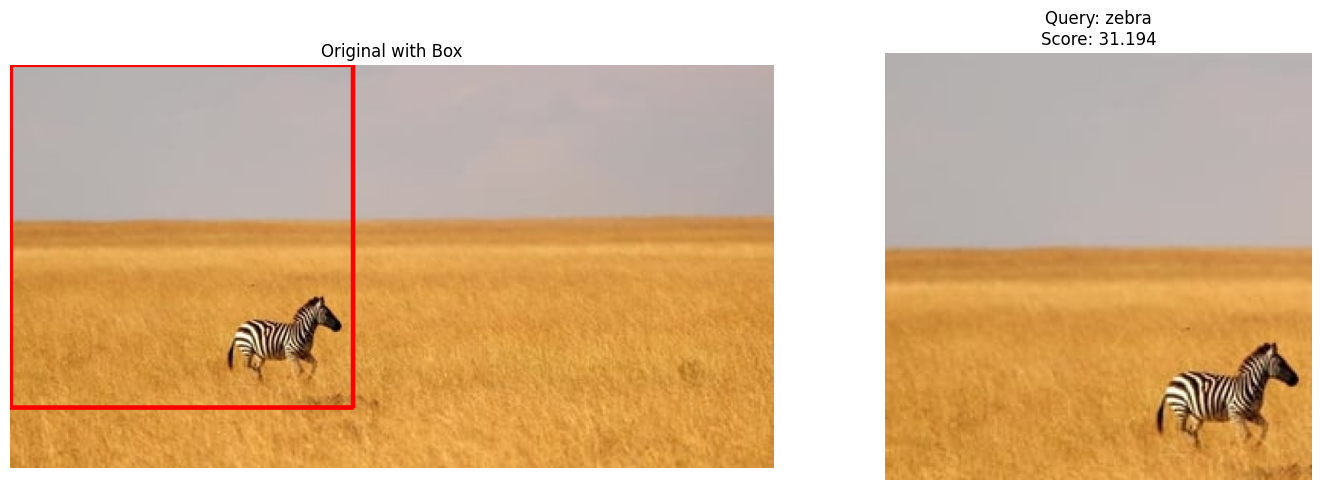

In [ ]:
# --- User Input ---
# Provide the URL for the image you want to analyze
image_url = input("Please enter the image URL: ")

# Provide the text prompts, separated by commas
queries_input = input("Enter your prompts (e.g., a man in a red shirt, a dog playing fetch): ")
queries = [q.strip() for q in queries_input.split(',')]

# --- Run the demo ---
if image_url and queries:
    demo(image_url, queries)
else:
    print("Please provide a valid URL and at least one prompt.")

In [ ]:
#https://images.tribuneindia.com/cms/gall_content/2016/3/2016_3$largeimg21_Monday_2016_013209330.jpg
#https://www.slowfood.com/wp-content/uploads/2023/12/wet-market-dhaka-1.jpg
#https://elements-resized.envatousercontent.com/elements-video-cover-images/2dbb75c9-f2a7-4f22-b4e1-1d428ece8e43/video_preview/video_preview_0000.jpg?w=500&cf_fit=cover&q=85&format=auto&s=805b1a1405109723a0d780bc3293e2673cacc74e66bcdcf3963cf2a1223dde11